In [19]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import scipy.misc


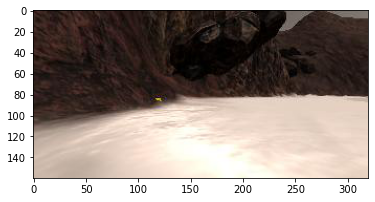

In [20]:
path = "../test_dataset/IMG/*"
img_list = glob.glob(path)
idx = np.random.randint(0,len(img_list)-1)
grid_img  = mpimg.imread(img_list[idx])
plt.imshow(grid_img )

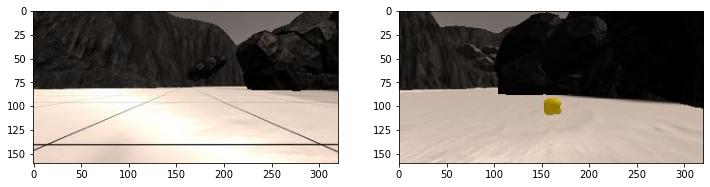

In [21]:
example_grid = "../calibration_images/example_grid1.jpg"
example_rock = "../calibration_images/example_rock1.jpg"

grid_image = mpimg.imread(example_grid)
rock_image = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12, 3))
plt.subplot((121))
plt.imshow(grid_image)
plt.subplot((122))
plt.imshow(rock_image)

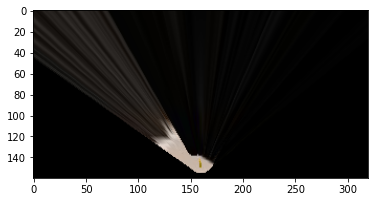

In [22]:
def perspect_transform(img,src,dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M , (img.shape[1], img.shape[0]))
    
    return warped


dst_size = 3
butt_ofset = 5;
source = np.float32([  [14,  175],
                       [300, 175],
                       [210, 105],
                       [125, 105]
                    ])
destination = np.float32([
    [rock_image.shape[1] / 2 - dst_size, rock_image.shape[0]-butt_ofset],
    [rock_image.shape[1] / 2 + dst_size, rock_image.shape[0]-butt_ofset],
    [rock_image.shape[1] / 2 + dst_size, rock_image.shape[0]-2*dst_size -butt_ofset],
    [rock_image.shape[1] / 2 - dst_size, rock_image.shape[0]-2*dst_size -butt_ofset]
])
warped = perspect_transform(rock_image, source, destination)
plt.imshow(warped)


    

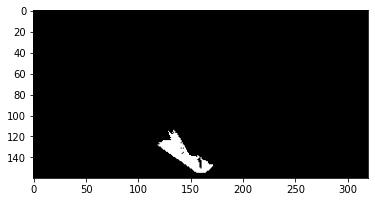

In [23]:
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    color_select = np.zeros_like(img[:,:,0])

    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])

    color_select[above_thresh] = 1
    return color_select

threshold = color_thresh(warped)
plt.imshow(threshold,cmap="gray")


9


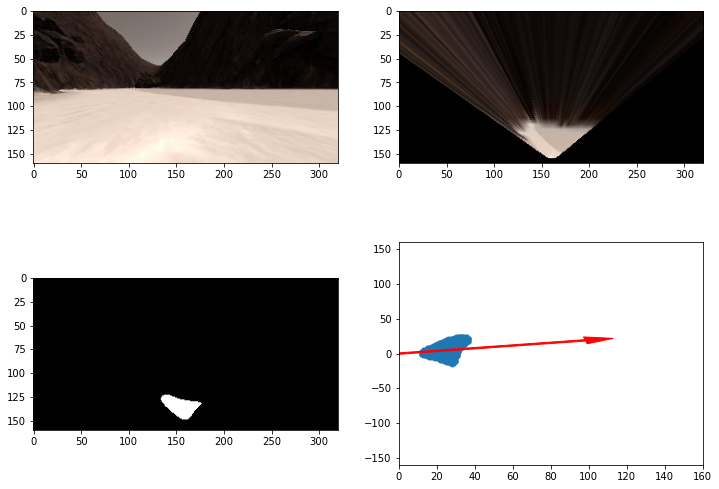

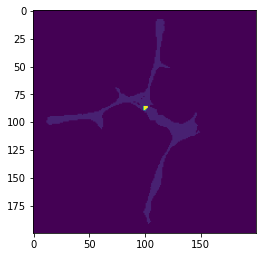

In [24]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float32)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float32)
    return x_pixel, y_pixel


# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world



#grab another random image
index = np.random.randint(0,len(img_list)-1)
image = mpimg.imread(img_list[index])
warped = perspect_transform(image,source,destination)
map_view = cv2.GaussianBlur(warped,(31,31),0)
threshold = color_thresh(map_view)

#calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix,ypix = rover_coords(threshold)
dist,angles = to_polar_coords(xpix,ypix)
mean_dir = np.mean(angles)

worldmap_path = "../calibration_images/map_bw.png"
worldmap = mpimg.imread(worldmap_path)
scale = 10

import pandas
df = pandas.read_csv("../test_dataset/robot_log.csv")
data_dict = df.to_dict()
mylist = data_dict["Path;SteerAngle;Throttle;Brake;Speed;X_Position;Y_Position;Pitch;Yaw;Roll"][index].split(";")

xpos = float(mylist[5])
ypos = float(mylist[6])
yaw = float(mylist[8])

navigable_x_world, navigable_y_world = pix_to_world(xpix, ypix, xpos, ypos, yaw, worldmap.shape[0], scale)

worldmap[navigable_y_world, navigable_x_world] += 10
print(index)

#do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshold,cmap="gray")
plt.subplot(224)
plt.plot(xpix,ypix,'.')
plt.ylim(-160,160)
plt.xlim(0,160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0,0,x_arrow,y_arrow,color='red',zorder=2,head_width=10,width=2)

fig2 = plt.figure(figsize=(12, 9))
plt.subplot(221)
plt.imshow(worldmap)



In [26]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change this path to your data directory
df = pd.read_csv('../test_dataset/robot_log.csv')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = -1 # This will be a running index, setting to -1 is a hack
                        # because moviepy (below) seems to run one extra iteration
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()

In [27]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    # 2) Apply perspective transform
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    # 4) Convert thresholded image pixel values to rover-centric coords
    # 5) Convert rover-centric pixel values to world coords
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1

    image = img
    dst_size = 5 
    # Set a bottom offset to account for the fact that the bottom of the image 
    # is not the position of the rover but a bit in front of it
    bottom_offset = 6
    src = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    dst = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])

    map_view = perspect_transform(img, src, dst)

    # middle between brightest sky and darkest ground from sample image
    navigable_thresholds = (160, 160, 160);
    #navigable_thresholds = (190, 178, 167);

    navigable = color_thresh(map_view, navigable_thresholds)

    obs = color_thresh(map_view, (0,0,0), navigable_thresholds)
    
    # Within 20 of high/low values from sample image
    rock_low_thresholds = (127, 94, 0) # 147 114 9   212 180 57
    rock_high_thresholds = (232, 200, 77)

    sample_detect = color_thresh(img, rock_low_thresholds, rock_high_thresholds)
    sample_detect = perspect_transform(sample_detect, src, dst)

    nav_xpix, nav_ypix = rover_coords(navigable)
    obs_xpix, obs_ypix = rover_coords(obs)
    samp_xpix, samp_ypix = rover_coords(sample_detect)

    nav_x, nav_y = pix_to_world(nav_xpix, nav_ypix, data.xpos[data.count], data.ypos[data.count], data.yaw[data.count], data.worldmap.shape[0], 10)
    obs_x, obs_y = pix_to_world(obs_xpix, obs_ypix, data.xpos[data.count], data.ypos[data.count], data.yaw[data.count], data.worldmap.shape[0], 10)
    samp_x, samp_y = pix_to_world(samp_xpix, samp_ypix, data.xpos[data.count], data.ypos[data.count], data.yaw[data.count], data.worldmap.shape[0], 10)

    data.worldmap[obs_y, obs_x, 0] += 1;
    data.worldmap[samp_y, samp_x, 1] += 1;
    data.worldmap[nav_y, nav_x, 2] += 1;

        
    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Periodicly clearing out low count map cells should increase fidelity!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False) 

KeyError: 'X_Position'

In [ ]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [ ]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))